# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and predict their gender based on face images. Please read carefully all the instructions before you start to write your code.

**Your Tasks**

You are supposed to train two CNN models.
- Model A: Train a CNN model from scratch, following a few restrictions. Save this model as `age_gender_A.keras`
- Model B: Fine-tune a pre-trained model to perform the same task. Save this model as `age_gender_B.keras`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During the assessment phase, your code will be tested on unseen test data.

**Performance Metric**

The evaluation of your models on the test set will be based on the following metrics:
- age estimation: - Mean Absolute Error (MAE)
- gender prediction: accuracy

**GPU Time Management**

Please use the available GPU time wisely, as there are some limitations on free GPU usage. It is said the users can use up to 12 hours in row in Google Colab. But many people found they reached its limit far less than 12 hours. To minimize the risk of reaching the limit, consider the following suggestions:
1. Ensure you have a stable internet connection.
2. Carefully validate your hyperparameters before starting the training process.
3. Based on past experience, each model should be trained in less than 2 hours. If the training time is significantly longer, you may need to adjust your model architecture.


## Setting Up: Mount the google drive
Mount your google drive to the notebook. Also don't forget to **enable GPU** before your training.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Visualize a few photos
It's always beneficial to thoroughly understand your data before beginning the training process. To get a first-hand impression of the dataset, please display a minimum of 20 images from the `train_val/` folder, along with their corresponding age and gender labels. This will help you gain initial insights into the dataset.

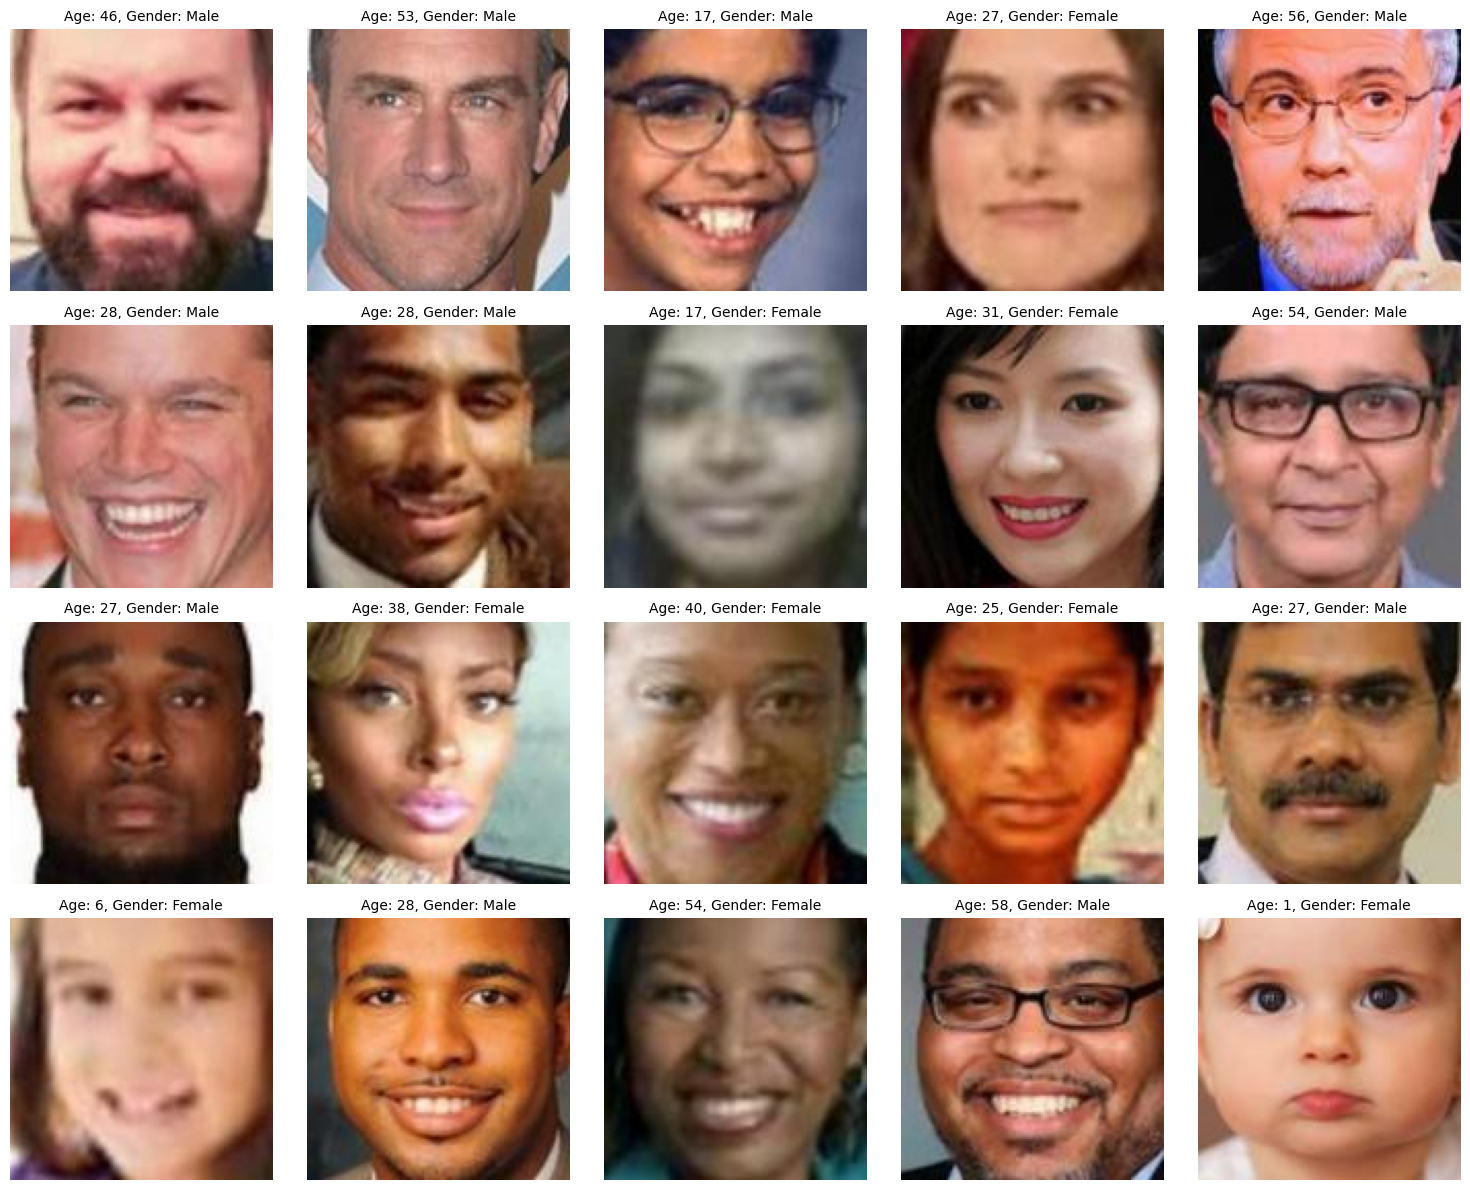

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow

dataset_path = "/content/drive/MyDrive/train_val" #for google colab
#dataset_path = "train_val" #for local running

image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

random.shuffle(image_files)
selected_images = image_files[:20]

def extract_label(filename):
    try:
        name = filename.split('_')
        age = int(name[0])
        gender = "Male" if name[1] == "0" else "Female"  # Second part is gender (0 = Male, 1 = Female)
        return age, gender
    except:
        return None, None  # Handle unexpected filename formats

# Plot 20 images in a 4x5 grid
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    if i < len(selected_images):
        img_path = os.path.join(dataset_path, selected_images[i])
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Extract labels from filename
        age, gender = extract_label(selected_images[i])
        label = f"Age: {age}, Gender: {gender}" if age is not None else "Unknown"

        # Display image
        ax.imshow(img)
        ax.set_title(label, fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

## Step 1: Data Pre-Processing
In this step, you will perform necessary pre-processing tasks before feeding the data into a CNN. The pre-processing includes:

1. Splitting the data into training and validation sets.
2. Loading image data, gender labels and age values, and rescaling pixel values (originally integers between 0 and 255) to the range [0, 1].
3. Data augmentation

The first two pre-processing steps have already been completed for you. Your task in this step is limited to:

3. Data augmentation

Please note:

- Do not modify any part of the provided code except the section marked with ########.
- Do not rescale the age values to the range [0,1], as the original values are used during the testing stage. Rescaling them would significantly impact testing performance.



In [5]:
folder_train_val = "/content/drive/MyDrive/train_val" #for google colab
#folder_train_val = "train_val" #for local running

all_image_files = [file for file in os.listdir(folder_train_val) if file.lower().endswith(('.jpg'))]

# Shuffle the dataset to ensure random distribution
random.seed(0)  # Ensure reproducibility
random.shuffle(all_image_files)

# Calculate the number of images for each set
n_train_val = len(all_image_files)
train_end = int(n_train_val * 0.8)

# Split the dataset
train_image_files = all_image_files[:train_end]
val_image_files = all_image_files[train_end:]
print(f"Number of images for training: {len(train_image_files)}")
print(f"Number of images for validation: {len(val_image_files)}")

def load_imgs_lables(dataset_path,filenames):
    print('load all image data, age and gender labels...')
    images = []
    age_labels = []
    gender_labels = []
    for current_file_name in filenames:
        img = cv2.imread(os.path.join(dataset_path, current_file_name))
        img = img / 255.0  # Normalize pixel values
        labels = current_file_name.split('_')
        age_label = int(labels[0])
        gender_label = int(labels[1])
        age_labels.append(age_label)
        gender_labels.append(gender_label)
        images.append(img)

# Convert to NumPy arrays
    images = np.array(images)
    age_labels = np.array(age_labels)
    gender_labels = np.array(gender_labels)
    return images, age_labels, gender_labels

# load data from the training set
train_images, train_age, train_gender = load_imgs_lables(folder_train_val,train_image_files)

# load data from the validation set
val_images, val_age, val_gender = load_imgs_lables(folder_train_val,val_image_files)

#
######### Add your code for data augmentation here #########
#
inputs = tensorflow.keras.Input(shape=(128, 128, 3))
print("here")
# Apply data augmentation layers to the inputs
augmented = tensorflow.keras.layers.RandomFlip("horizontal")(inputs)
print("here")
augmented = tensorflow.keras.layers.RandomRotation(0.2)(augmented)
print("here")
augmented = tensorflow.keras.layers.RandomZoom(0.1)(augmented)
print("here")
augmented = tensorflow.keras.layers.RandomTranslation(0.1, 0.1)(augmented)
print("here")


Number of images for training: 4000
Number of images for validation: 1000
load all image data, age and gender labels...
load all image data, age and gender labels...
here
here
here
here
here


## STEP2A: Build your own CNN network
In this step, you will define your own CNN model for identifying gender and predicting age. Although there are two tasks, you only need to build one CNN model with two outputs. You may refer to online resources for solutions.

Here are the key requirements and restrictions for your network:
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2. Although it is technically correct to treat gender classification as a multi-class problem with 2 classes, i.e., 2 units in the last layer, the test code only supports a 1-unit last-layer configuration for the gender branch.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	Incorporate techniques to prevent overfitting as appropriate.

At the end of your implementation, use `modelA.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 126, 126, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 63, 63, 32)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 63, 63, 32)     │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 30, 30, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 30, 30, 64)     │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 14, 14, 128)    │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 14, 14, 128)    │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 12, 12, 256)    │        295,168 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 6, 6, 256)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 6, 6, 256)      │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 9216)           │              0 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      2,359,552 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 1)              │            257 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │            257 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,748,482 (10.48 MB)

 Trainable params: 2,748,482 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

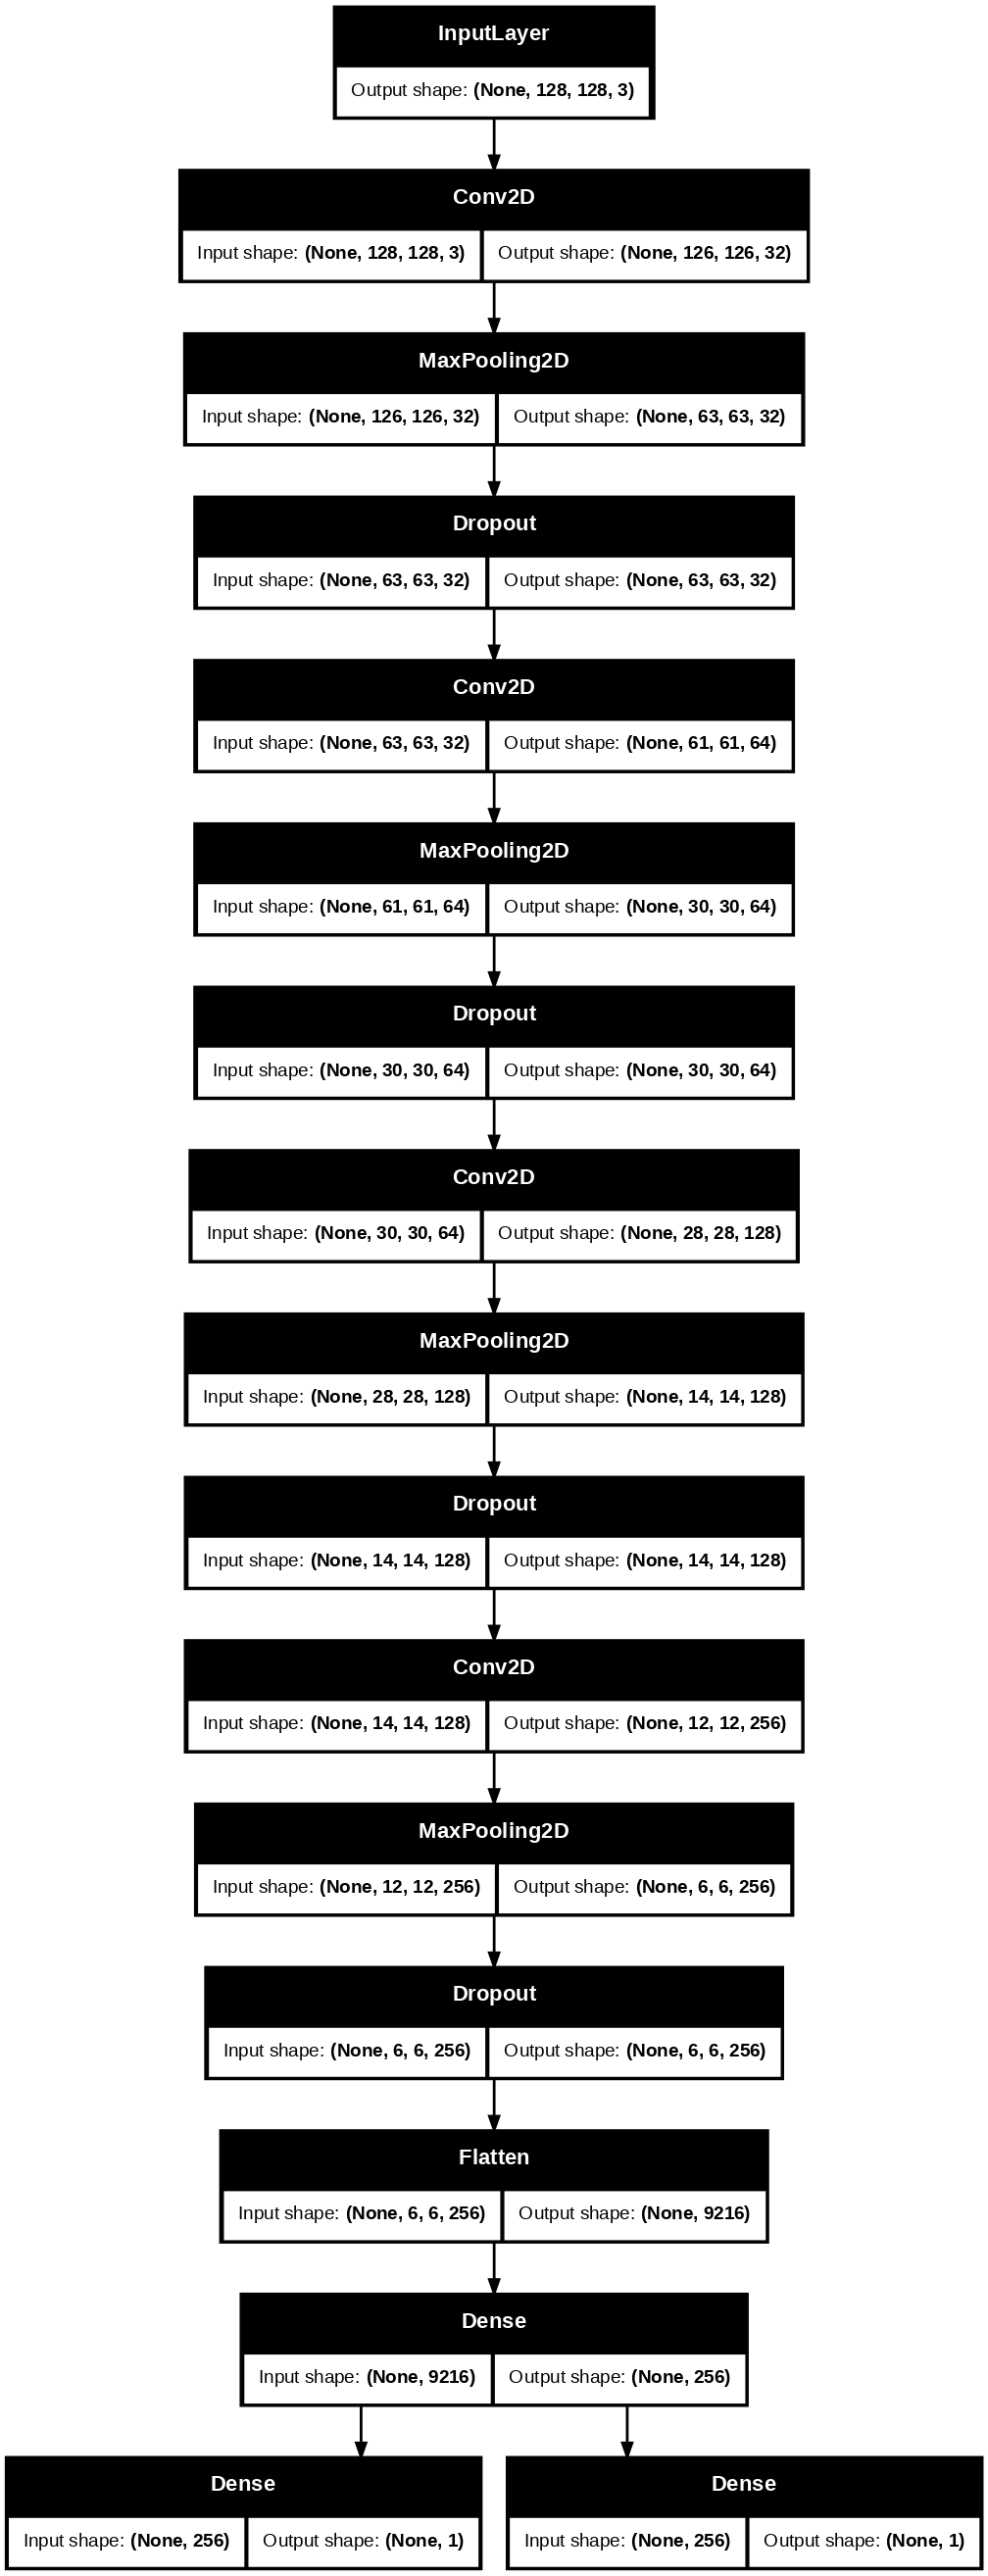

In [7]:

x = tensorflow.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tensorflow.keras.layers.MaxPooling2D(2, 2)(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)

x = tensorflow.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tensorflow.keras.layers.MaxPooling2D(2, 2)(x)
x = tensorflow.keras.layers.Dropout(0.3)(x)

x = tensorflow.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tensorflow.keras.layers.MaxPooling2D(2, 2)(x)
x = tensorflow.keras.layers.Dropout(0.3)(x)

x = tensorflow.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tensorflow.keras.layers.MaxPooling2D(2, 2)(x)
x = tensorflow.keras.layers.Dropout(0.3)(x)

x = tensorflow.keras.layers.Flatten()(x)
x = tensorflow.keras.layers.Dense(256, activation='relu')(x)

gender = tensorflow.keras.layers.Dense(1, activation='sigmoid', name='gender')(x)
age = tensorflow.keras.layers.Dense(1, activation='linear', name='age')(x)

modelA = tensorflow.keras.Model(inputs=inputs, outputs=[gender, age])

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True,dpi=100)

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.keras")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()`** to save the entire model (including a model's architecture, weights, and training configuration) as a `.keras` zip archive. Don't save it with `save_weights()`.


In [9]:
modelA.compile(
    optimizer=tensorflow.keras.optimizers.Adam(),
    loss={
        "gender": tensorflow.keras.losses.BinaryCrossentropy(),
        "age": tensorflow.keras.losses.MeanAbsoluteError(),
    },
    metrics={
        "gender": ["accuracy"],
        "age": ["mae"]
    }
)

historyA = modelA.fit(
    x=train_images,
    y={
        "gender": train_gender,
        "age": train_age
    },
    validation_data=(
        val_images,
        {
            "gender": val_gender,
            "age": val_age
        }
    ),
    epochs=20 ,
    batch_size=32
)

folder_models = "content/drive/MyDrive/models/"
modelA.save(folder_models+'age_gender_A.keras')
print("success")

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - age_loss: 10.4442 - age_mae: 10.4442 - gender_accuracy: 0.7869 - gender_loss: 0.4413 - loss: 10.8855 - val_age_loss: 9.9228 - val_age_mae: 9.8955 - val_gender_accuracy: 0.7810 - val_gender_loss: 0.4397 - val_loss: 10.3326
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - age_loss: 10.0348 - age_mae: 10.0348 - gender_accuracy: 0.7889 - gender_loss: 0.4372 - loss: 10.4720 - val_age_loss: 10.0476 - val_age_mae: 10.0508 - val_gender_accuracy: 0.8120 - val_gender_loss: 0.4113 - val_loss: 10.4572
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - age_loss: 9.2755 - age_mae: 9.2755 - gender_accuracy: 0.8001 - gender_loss: 0.4277 - loss: 9.7032 - val_age_loss: 9.7088 - val_age_mae: 9.6774 - val_gender_accuracy: 0.7880 - val_gender_loss: 0.4373 - val_loss: 10.1136
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - age_loss: 9.4444 - age_mae: 9.4444 - gender_accuracy: 0.8088 - gender_loss: 0.4166 - loss: 9.8611 - val_age_loss: 

FileNotFoundError: [Errno 2] No such file or directory: 'content/drive/MyDrive/models/age_gender_A.keras'

## STEP4A: Draw the learning curves
Draw four learning curve figures for model A as follows.
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

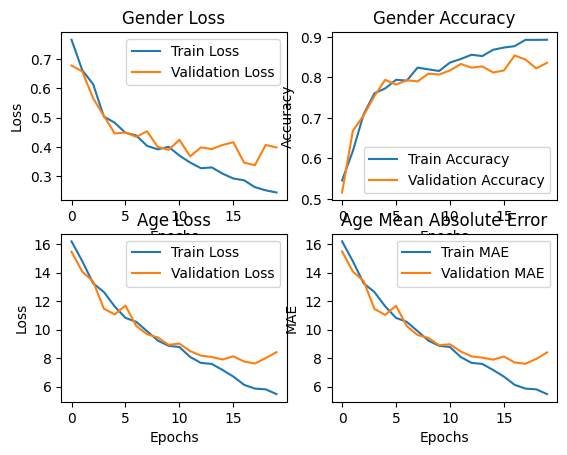

In [ ]:
gender_train_loss = historyA.history['gender_loss']
gender_val_loss = historyA.history['val_gender_loss']

gender_train_accuracy = historyA.history['gender_accuracy']
gender_val_accuracy = historyA.history['val_gender_accuracy']

age_train_loss = historyA.history['age_loss']
age_val_loss = historyA.history['val_age_loss']

age_train_accuracy = historyA.history['age_mae']
age_val_accuracy = historyA.history['val_age_mae']

epochs = range(len(gender_train_loss))


# Gender Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, gender_train_loss, label='Train Loss')
plt.plot(epochs, gender_val_loss, label='Validation Loss')
plt.title('Gender Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gender Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, gender_train_accuracy, label='Train Accuracy')
plt.plot(epochs, gender_val_accuracy, label='Validation Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Age Loss
plt.subplot(2, 2, 3)
plt.plot(epochs, age_train_loss, label='Train Loss')
plt.plot(epochs, age_val_loss, label='Validation Loss')
plt.title('Age Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Age MAE
plt.subplot(2, 2, 4)
plt.plot(epochs, age_train_accuracy, label='Train MAE')
plt.plot(epochs, age_val_accuracy, label='Validation MAE')
plt.title('Age Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

## STEP2B: Build a CNN network based on a pre-trained model
Choose an existing CNN architecture pre-trained on ImageNet and fine-tune it on this dataset.

As with Model A, **do not resize the input image size**.
Ensure that the output layer for **the gender branch has only 1 unit**.

At the end of the cell, use `modelB.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

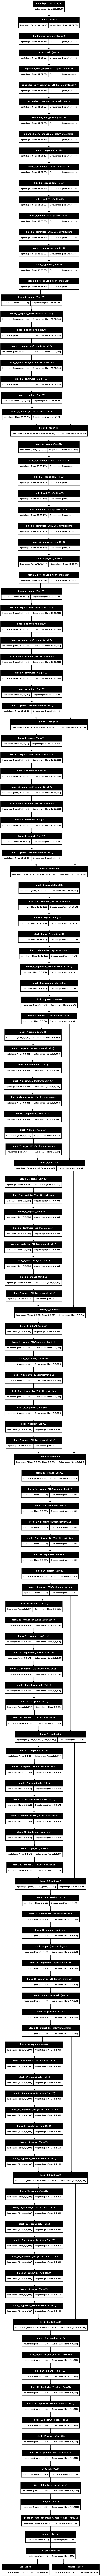

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# MobileNetV2 with our specified input shape
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))


base_model.trainable = False


x = GlobalAveragePooling2D()(base_model.output)


x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

#creating the branches for both estimaters
age_output = Dense(1, activation="linear", name="age")(x)
gender_output = Dense(1, activation="sigmoid", name="gender")(x) # Same activation functions as before



modelB = Model(inputs=base_model.input, outputs=[age_output, gender_output])

modelB.summary()
plot_model(modelB, to_file="modelB_architecture.png", show_shapes=True, show_layer_names=True)



## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.keras` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [ ]:
import tensorflow as tf
import os

# same compilation structure as before
modelB.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={"age": "mean_absolute_error", "gender": "binary_crossentropy"},
    metrics={"age": "mae", "gender": "accuracy"}
)

# Training, keeping the parameters the same as previous
historyB = modelB.fit(
    x=train_images,
    y={"age": train_age, "gender": train_gender},
    validation_data=(val_images, {"age": val_age, "gender": val_gender}),
    epochs=20,
    batch_size=32
)

folder_models = "/content/drive/MyDrive/models"
modelB.save(folder_models+"age_gender_B.keras")

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - age_loss: 16.5231 - age_mae: 16.5231 - gender_accuracy: 0.6109 - gender_loss: 1.0209 - loss: 17.5440 - val_age_loss: 10.8632 - val_age_mae: 10.8271 - val_gender_accuracy: 0.8170 - val_gender_loss: 0.4500 - val_loss: 11.2702
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - age_loss: 10.6535 - age_mae: 10.6535 - gender_accuracy: 0.7474 - gender_loss: 0.6260 - loss: 11.2794 - val_age_loss: 10.0286 - val_age_mae: 10.0054 - val_gender_accuracy: 0.8030 - val_gender_loss: 0.4547 - val_loss: 10.4460
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - age_loss: 10.2937 - age_mae: 10.2937 - gender_accuracy: 0.7542 - gender_loss: 0.5588 - loss: 10.8525 - val_age_loss: 10.3435 - val_age_mae: 10.2981 - val_gender_accuracy: 0.8240 - val_gender_loss: 0.4263 - val_loss: 10.7127
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - age_loss: 9.6814 - age_mae: 9.6814 - gender_accuracy: 0.7878 - gender_loss: 0.4829 - loss: 10.1643 - val_ag

## STEP4B: Draw the learning curves
Draw four learning curve figures for model B as follows.
1. The loss of the gender classification over the training and validation set
2. The accuracy of the gender classification over the training and validation set
3. The loss of the age estimation over the training and validation set
4. The MAE of the age estimation over the training and validation set

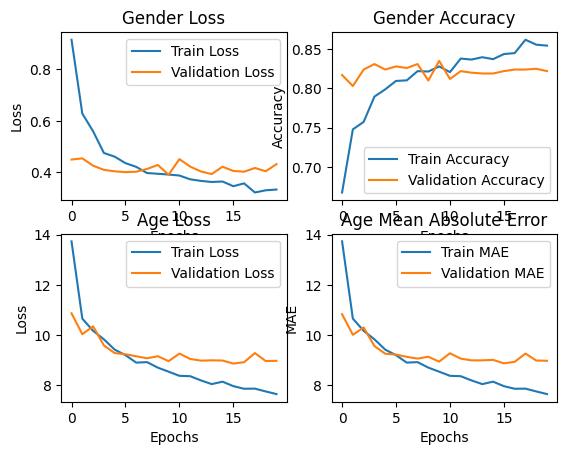

In [ ]:
gender_train_loss = historyB.history['gender_loss']
gender_val_loss = historyB.history['val_gender_loss']

gender_train_accuracy = historyB.history['gender_accuracy']
gender_val_accuracy = historyB.history['val_gender_accuracy']

age_train_loss = historyB.history['age_loss']
age_val_loss = historyB.history['val_age_loss']

age_train_accuracy = historyB.history['age_mae']
age_val_accuracy = historyB.history['val_age_mae']

epochs = range(len(gender_train_loss))


# Gender Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, gender_train_loss, label='Train Loss')
plt.plot(epochs, gender_val_loss, label='Validation Loss')
plt.title('Gender Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gender Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, gender_train_accuracy, label='Train Accuracy')
plt.plot(epochs, gender_val_accuracy, label='Validation Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Age Loss
plt.subplot(2, 2, 3)
plt.plot(epochs, age_train_loss, label='Train Loss')
plt.plot(epochs, age_val_loss, label='Validation Loss')
plt.title('Age Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Age MAE
plt.subplot(2, 2, 4)
plt.plot(epochs, age_train_accuracy, label='Train MAE')
plt.plot(epochs, age_val_accuracy, label='Validation MAE')
plt.title('Age Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

## STEP5: Evaluate the model on the test set
I will load your two models for testing. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#